<span style="font-family:Papyrus; font-size:3em;">Homework 2</span>

<span style="font-family:Papyrus; font-size:2em;">Cross Validation</span>

# Problem

In this homework, you will use cross validation to analyze the effect on model quality
of the number of model parameters and the noise in the observational data.
You do this analysis in the context of design of experiments.
The two factors are (i) number of model parameters and (ii) the noise in the observational data;
the response will be the $R^2$ of the model (actually the $R^2$ averaged across the folds of
cross validation).

You will investigate models of linear pathways with 2, 4, 6, 8, 10 parameters.
For example, a two parameter model is use $S_1 \xrightarrow{v_1} S_2 \xrightarrow{v_3} S_3$,
where $v_i = k_i s_i$, $k_i$ is a parameter to estimate, and $s_i$ is the concentration of $S_i$.
The initial concentration of $S_1 = 10$, and the true value of $k_i$ is $i$. Thus, for a two parameter model,
$k_1 = 1$, $k_2 = 2$.

You will generate the synthetic data by adding a
noise term to the true model.
The noise term is drawn from a normal distribution with mean 0
and standard deviations of 0.2, 0.5, 0.8, 1.0, and 1.5, depending on the experiment.

You will design experiments, implement codes to run them, run the experiments, and interpret the results.
The raw output of these experiments will be
a table structured as the one below.
Cell values will be the average $R^2$ across the folds of the cross validation done with
one level for each factor.

 |   | 2 | 4 | 6 | 8 | 10
  | -- | -- | -- | -- | -- | -- |
 0.2 | ? | ? | ? | ? | ?
 0.5 | ? | ? | ? | ? | ?
 0.8 | ? | ? | ? | ? | ?
 1.0 | ? | ? | ? | ? | ?
 1.5 | ? | ? | ? | ? | ?
 

1. (2 pt) **Generate Models.** Write (or generate) the models in Antimony, and produce plots for their true values. Use a simulation time
of 10 and 100 points.

1. (1 pt) **Generate Synthetic Data.** Write a function that creates synthetic data given the parameters std 
and numParameter.

1. (1 pt) **Extend ``CrossValidator``.** You will extend ``CrossValidator`` (in ``common/util_crossvalidation.py``)
by creating a subclass ``ExtendedCrossValidator`` that has the method
``calcAvgRsq``. The method takes no argument (except ``self``) and returns the average value of
$R^2$ for the folds. Don't forget to document the function and include at least one tests.

1. (4 pt) **Implement ``runExperiments``.** This function has inputs: (a) list of the number of parameters for the
models to study and (b) list of the standard deviations of the noise terms.
It returns a dataframe with: columns are the number of parameters; rows (index) are the standard deviations of noise;
and values are the average $R^2$ for the folds defined by the levels of the factors.
Run experiments that produce the tables described above using five hold cross validation and 100 simulation points.

1. (4 pt) **Calculate Effects.** Using the baseline standard deviation of noise of 0.8, number of parameters of 6, calculate $\mu$, $\alpha_{i,k_i}$,
$\gamma_{i,i_k,j,k_j}$.

1. (3 pt) **Analysis.** Answer the following questions
   1. What is the effect on $R^2$ as the number of parameters increases? Why?
   1. How does the noise standard deviation affect $R^2$? Why?
   1. What are the interaction effects and how do they influence the response (average $R^2$)?
   
**Please do your homework in a copy of this notebook, maintaining the sections.**

# Programming Preliminaries
This section provides the setup to run your python codes.

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIR = "/home/ubuntu/advancing-biomedical-models/common"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIR = "/content/drive/My Drive/Winter 2021/common"
import sys
sys.path.insert(0, CODE_DIR)

In [2]:
import util_crossvalidation as ucv
from SBstoat.namedTimeseries import NamedTimeseries, TIME

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

In [3]:
END_TIME = 5
NUM_POINT = 100
NOISE_STD = 0.5
# Column names
C_NOISE_STD = "noisestd"
C_NUM_PARAMETER = "no. parameters"
C_VALUE = "value"
#
NOISE_STDS = [0.2, 0.5, 0.8, 1.0, 1.5]
NUM_PARAMETERS = [2, 4, 6, 8, 10]

In [4]:
def isSame(collection1, collection2):
    """
    Determines if two collections have the same elements.
    """
    diff = set(collection1).symmetric_difference(collection2)
    return len(diff) == 0
    
# Tests
assert(isSame(range(3), [0, 1, 2]))
assert(not isSame(range(4), range(3)))

# Generate Models

In [5]:
MODEL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
k1 = 1
k2 = 2
"""
rr = te.loada(MODEL)

In [6]:
class LinearModel(object):
    
    def __init__(self, numParameter, s1Value=10):
        """
        numParameter: int
            number of parameters in the model
        s1Value: float
            Initial value for S1
        """
        self.numParameter = numParameter
        self.s1Value = s1Value
        #
        # modelStr - Antimony model
        # parameterDct - true values of parameters
        self.modelStr, self.parameterDct = self._generateModel()
        self.parameterNames = list(self.parameterDct.keys())
        # Calculated by other methods
        self.resultTS = None  # Simulation result
        
    def _generateModel(self):
        """
        Constructs an antimony model.
        
        Returns
        -------
        str: antimony model
        list-str: model parameters
        dict:
            key: parameterName
            value: true value
        """
        def mkSpeciesInitialization(idx, value=0):
            return "\nS%d = %2.2f" % (idx, value)
        #
        reactionStr = ""
        initializationStr = ""
        parameterDct = {}
        for idx in range(1, self.numParameter+1):
            if idx == 1:
                value = self.s1Value
            else:
                value = 0
            parameterName = "k%d" % idx
            parameterDct[parameterName] = idx
            initializationStr += mkSpeciesInitialization(idx, value)
            if idx == self.numParameter:
                    initializationStr += mkSpeciesInitialization(idx + 1, 0)
            initializationStr += "\n%s = %2.2f" % (parameterName, 1.0*idx)
            reactionStr += "\nS%d -> S%d; k%d*S%d" % (idx, idx+1, idx, idx)
        modelStr = "%s\n%s" % (reactionStr, initializationStr)
        return modelStr, parameterDct
    
    def simulate(self, endTime=END_TIME, numPoint=NUM_POINT):
        """
        Simulates the model.
        
        Parameters
        ----------
        endTime: float
            end of the simulation
        numPoint: int
            number of points in the simulation
        """
        rr = te.loada(self.modelStr)
        arr = rr.simulate(0, endTime, numPoint)
        self.resultTS = NamedTimeseries(namedArray=arr)
    
    def plotTrueModel(self, **kwargs):
        """
        Plots the result of a simulation.
        
        Parameters
        ----------
        kwargs: dict
            arguments passed to plot
            
        Returns
        -------
        Matplotlib.Axes
        """
        if self.resultTS is None:
            self.simulate()
        return ucv.plotTS(self.resultTS, linetype="line", **kwargs)

# Tests
numParameter = 3
model = LinearModel(numParameter)
_ = te.loada(model.modelStr)
assert(len(model.parameterDct) == numParameter)
# All species and constants are present
for term in ["S", "k"]:
    trues = ["%s%d" % (term, n) in model.modelStr for n in range(1, numParameter+1)]            
    assert(all(trues))
#   simulate
model.simulate()
assert(len(model.resultTS) > 0)
#   plotResult
model.plotTrueModel(title="test", isPlot=False)

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

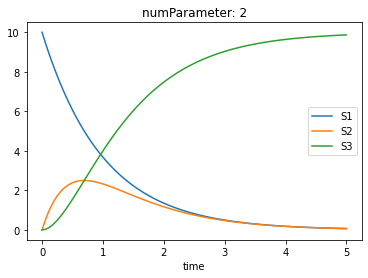

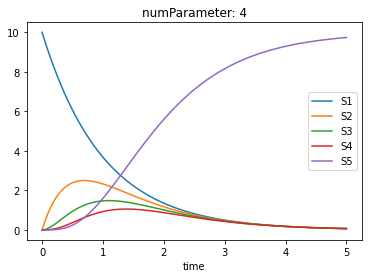

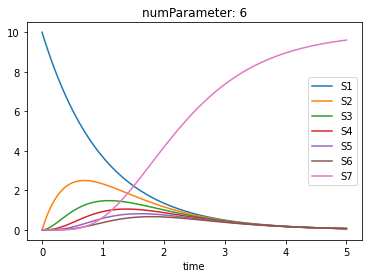

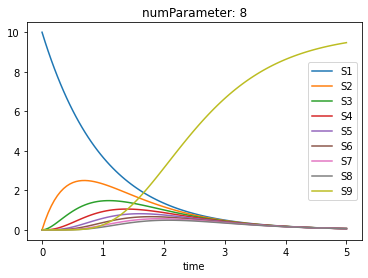

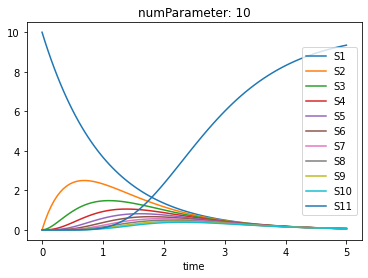

In [7]:
for numParameter in NUM_PARAMETERS:
    model = LinearModel(numParameter)
    model.plotTrueModel(title="numParameter: %d" % numParameter)

# Generate Synthetic Data

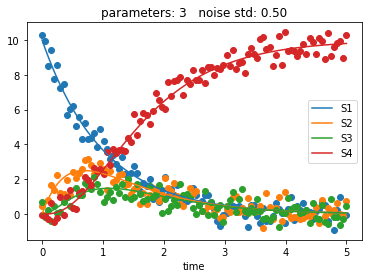

In [8]:
class ExtendedLinearModel(LinearModel):
    """Extends Model by providing generated observations."""
    
    def __init__(self, *args, **kwargs):
        """
        numParameter: int
            number of parameters in the model
        """
        super().__init__(*args, **kwargs)
        self.noiseStd = None
        self.observedTS = None
    
    def generateObserved(self, noiseStd=NOISE_STD, **kwargs):
        """
        Creates synthetic data for the model.

        model: Model
        noiseStd: float
        kwargs: dict
            optional keywords passed to run model
        """
        self.noiseStd = noiseStd
        self.simulate(**kwargs)
        self.observedTS = ucv.makeSyntheticData(fittedTS=self.resultTS, std=noiseStd)
        
    def plotTrueAndGeneratedData(self, isPlot=True):
        ax = self.plotTrueModel(isPlot=isPlot)
        if self.observedTS is None:
            self.generateObserved()
        title = "parameters: %d   noise std: %2.2f" % (self.numParameter, self.noiseStd)
        ucv.plotTS(self.observedTS, title=title, isPlot=isPlot, ax=ax)

# Tests
model = ExtendedLinearModel(3)
model.generateObserved()
assert(len(model.observedTS) == len(model.observedTS))
#  plotTrueAndGeneratedData
model.plotTrueAndGeneratedData()

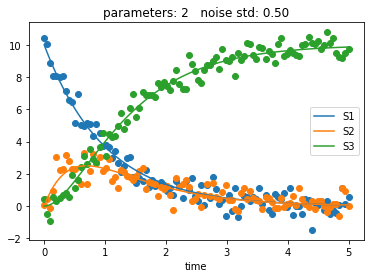

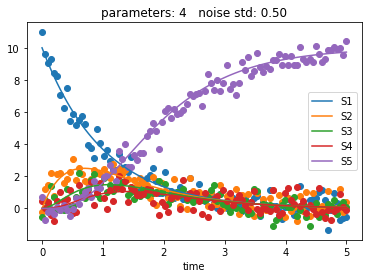

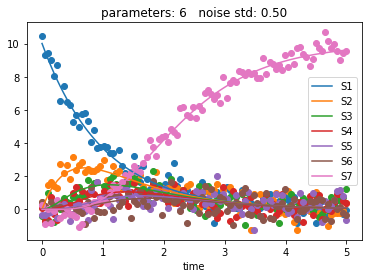

In [9]:
# Here are some examples of the data
for numParameter in [2, 4, 6]:
    model = ExtendedLinearModel(numParameter)
    model.plotTrueAndGeneratedData()

# ``ExtendedCrossValidator``

Hint: Subclass using ``class ExtendedCrossValidator(ucv.CrossValidator):``.

In [10]:
class ExtendedCrossValidator(ucv.CrossValidator):
    """Calculates the average Rsq for the folds."""
    
    def calcAvgRsq(self):
        """
        Calculates the average Rsq across the folds in the cross validation.
        
        Returns
        -------
        float
        """
        return np.mean(self.rsqs)
    
# Tests
numFold = 5
numParameter = 4
model = ExtendedLinearModel(numParameter)
model.generateObserved(noiseStd=1.5)
validator = ExtendedCrossValidator(numFold, model.modelStr, model.observedTS, model.parameterNames,
    trueParameterDct=model.parameterDct, method="least_squares",
    lower=0, upper=100)
validator.execute()
avgRsq = validator.calcAvgRsq()
assert(avgRsq >= 0)
assert(avgRsq <= 1.0)

# Implement ``runExperiments``

In [11]:
def runExperiments(numParameters, noiseStds, numFold=5, **kwargs):
    """
    Constructs tables for the results of computational experiments.
    Experiments are described by the collection of values for the
    number of parameters in the model and the standard deviation of noise.
    
    Parameters
    ----------
    numParameters: list-int
    noiseStds: list-float
    numFold: int
    kwargs: dict
        optional arguments for ExtendedCrossValidator
    
    Returns
    -------
    pd.DataFrame: rsqDF - average R2 for folds
        columns: NUM_PARAMETER in model
        index: NOISE_STD of observational data
        values: average R2
    """
    def mkTable(dct):
        """
        Creates a dataframe table from a dictionary.
        Columns are the number of parameters.
        Rows are the standard deviation of the noise.
        """
        df = pd.DataFrame(dct)
        df = df.set_index(C_NOISE_STD)
        tableDF = df.pivot_table(values=C_VALUE,columns=C_NUM_PARAMETER,
                                 index=C_NOISE_STD)
        return tableDF
    def updateDct(dct, noiseStd, numParameter, value):
        """
        Update entries in the dictionary.
        """
        dct[C_NOISE_STD].append(noiseStd)
        dct[C_NUM_PARAMETER].append(numParameter)
        dct[C_VALUE].append(value)
    #
    rsqDct = parameterdct = {C_NOISE_STD: [], C_NUM_PARAMETER: [], C_VALUE: []}
    for noiseStd in noiseStds:
        for numParameter in numParameters:
            model = ExtendedLinearModel(numParameter)
            model.generateObserved(noiseStd=noiseStd)
            validator = ExtendedCrossValidator(numFold, model.modelStr, model.observedTS, 
                model.parameterNames,
                trueParameterDct=model.parameterDct, **kwargs)
            validator.execute()
            updateDct(rsqDct, noiseStd, numParameter,
                      np.mean(validator.rsqs))
    rsqDF = mkTable(rsqDct)
    return rsqDF

# Tests
numParameters = [2, 4, 10]
noiseStds = [0.5, 0.8, 1.5]
rsqDF = runExperiments(numParameters, noiseStds)
for df in [rsqDF]:
    assert(isSame(numParameters, df.columns))
    assert(isSame(noiseStds, df.index))

In [12]:
RSQ_DF = runExperiments(NUM_PARAMETERS, NOISE_STDS)
RSQ_DF

no. parameters,2,4,6,8,10
noisestd,,,,,
0.2,0.996752,0.994793,0.992912,0.990576,0.988214
0.5,0.983892,0.970256,0.955058,0.945657,0.929228
0.8,0.951154,0.926042,0.889788,0.861121,0.846397
1.0,0.933800,0.887564,0.819429,0.811879,0.757129
1.5,0.862122,0.753387,0.705615,0.614277,0.570123


# Calculate Effects
Here, we calculate $\mu$, $\alpha_{i, k_i}$, and $\gamma_{i, k_i, j, k_j}$.

In [13]:
def calculateEffects(tableDF):
    """
    """
    columns = tableDF.columns.tolist()
    rows = tableDF.index.tolist()
    numRow = len(rows)
    numCol = len(columns)
    #
    if numRow % 2 != 1:
        raise ValueError("Must have an odd number of rows.")
    if numCol % 2 != 1:
        raise ValueError("Must have an odd number of columns.")
    centerRow = numRow // 2 
    centerCol = numCol // 2 
    #
    mu = tableDF.loc[rows[centerRow], columns[centerCol]]
    #
    rowAlphaSer = tableDF.loc[rows, columns[centerCol]] - mu
    columnAlphaSer = tableDF.loc[rows[centerRow], columns] - mu
    # Calculate the values for each entry
    gammaDF = tableDF.copy()
    for column in columns:
        for row in rows:
            gammaDF.loc[row, column] = gammaDF.loc[row, column]  \
                  - mu - rowAlphaSer.loc[row] - columnAlphaSer.loc[column]
    #
    return mu, rowAlphaSer, columnAlphaSer, gammaDF
                              
# Tests
numParameters = [2, 4, 6]
noiseStds = [0.5, 0.8, 1.5]
rsqDF = runExperiments(numParameters, noiseStds)
mu, rowAlphaSer, columnAlphaSer, gammaDF = calculateEffects(rsqDF)
assert((0 <= mu) and (mu <= 1.0))
assert(len(rowAlphaSer) == len(noiseStds))
assert(len(columnAlphaSer) == len(numParameters))

Calculate Rsqs and then calculate mu, alpha, gamma

In [14]:
mu, noiseStdAlphaSer, numParameterAlphaSer, gammaDF = calculateEffects(RSQ_DF)

In [15]:
mu

0.8897881821618581

In [16]:
# Alpha for noise standard deviations
noiseStdAlphaSer

noisestd
0.2    0.103124
0.5    0.065269
0.8    0.000000
1.0   -0.070359
1.5   -0.184173
Name: 6, dtype: float64

In [17]:
# Alpha for number of parameters
numParameterAlphaSer

no. parameters
2     0.061366
4     0.036254
6     0.000000
8    -0.028667
10   -0.043391
Name: 0.8, dtype: float64

In [18]:
gammaDF

no. parameters,2,4,6,8,10
noisestd,,,,,
0.2,-0.057525,-0.034372,0.0,0.026332,0.038693
0.5,-0.032532,-0.021056,0.0,0.019267,0.017562
0.8,0.000000,0.000000,0.0,0.000000,0.000000
1.0,0.053005,0.031882,0.0,0.021117,-0.018909
1.5,0.095141,0.011518,0.0,-0.062671,-0.092101


# Analysis

**What is the effect on $R^2$ as the number of parameters increases? Why?**
  

$R^2$ decreases because there are more parameters to estimate with the same data.

**How does the noise standard deviation affect $R^2$? Why?**

$R^2$ decreases with noise.

**What are the interaction effects and how do they influence the response (average $R^2$)?**

The interaction effects are mostly small, and they generally increase with the number of parameters in the model.